In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
data_filename = "./installment2_id03.csv"
data_df = pd.read_csv(data_filename)
test_filename = "./installment2_evaluation_data.csv"
test_df = pd.read_csv(test_filename)

## Missing Value
There are no missing values here.

In [39]:
def df_summary(df):
    summary = []

    n_rows, n_cols = df.shape

    for col in df.columns:
        s = df[col]
        info = {
            "variable": col,
            "dtype": s.dtype,
            "n_missing": s.isna().sum(),
            "pct_missing": s.isna().mean(),
        }

        if pd.api.types.is_numeric_dtype(s):
            info.update({
                "min": s.min(),
                "max": s.max(),
                "n_unique": s.nunique(),
            })
        else:
            info.update({
                "n_unique": s.nunique(),
                "categories": s.dropna().unique()[:10],
            })

        summary.append(info)

    summary_df = pd.DataFrame(summary)

    return summary_df, n_rows, n_cols

summary_df, n_rows, n_cols = df_summary(data_df)
print(f"For training dataset, rows: {n_rows}, columns: {n_cols}")
display(summary_df)

For training dataset, rows: 2263, columns: 11


,variable,dtype,n_missing,pct_missing,min,max,n_unique,categories
0,PRSM,float64,0,0.0,-0.974979,2.976943e+00,2263,NaN
1,FICO,int64,0,0.0,482.000000,8.500000e+02,299,NaN
2,TotalAmtOwed,int64,0,0.0,10136.000000,1.791524e+06,2259,NaN
3,Volume,int64,0,0.0,2393.000000,8.284497e+06,2256,NaN
4,Stress,float64,0,0.0,0.004609,7.044360e-01,2263,NaN
5,Num_Delinquent,int64,0,0.0,3.000000,8.000000e+00,6,NaN
6,Num_CreditLines,int64,0,0.0,8.000000,1.300000e+01,6,NaN
7,WomanOwned,int64,0,0.0,0.000000,1.000000e+00,2,NaN
8,CorpStructure,object,0,0.0,NaN,NaN,4,"[LLC, Corp, Partner, Sole]"
9,NAICS,int64,0,0.0,441120.000000,7.225140e+05,21,NaN


## Outlier & Range Check

We check:
- **FICO** should be in [300, 850]. Values outside this range are data errors.
- **PRSM** should be ≥ 0.
- **Stress** is a ratio and should be non-negative.
- Any observation with extreme leverage could distort the regression.

**Outlier handling notes:**

- Remove records with negative `PRSM` values. 
- `TotalAmtOwed` and `Volume` have right-tailed outliers, but log-transformation will mitigate their leverage effect.

=== Range Validation ===
FICO outside [300, 850]: 0 records
PRSM < 0: 4 records


,PRSM,FICO,TotalAmtOwed,Volume,Stress,Num_Delinquent,Num_CreditLines,WomanOwned,CorpStructure,NAICS,Months
620,-0.813173,698,51311,13042,0.327857,4,10,1,Corp,459210,15
931,-0.974979,735,285143,260634,0.091170,4,12,0,Corp,722330,20
1513,-0.838569,688,377793,165021,0.190780,4,11,1,Sole,722330,18
1741,-0.023162,679,38315,16011,0.199420,4,9,0,Sole,445240,30


Stress < 0: 0 records
Num_Delinquent > Num_CreditLines: 0 records


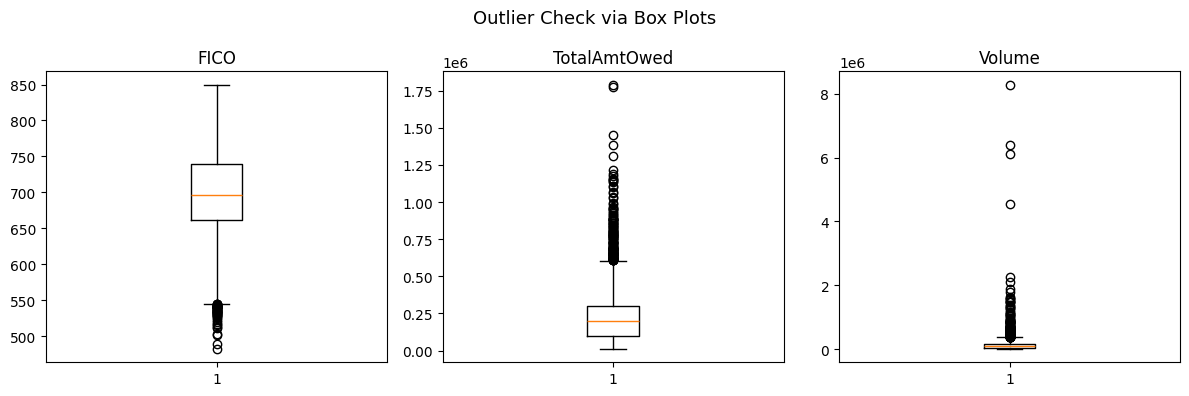

In [40]:
# Range validation checks
print("=== Range Validation ===")

# FICO range
fico_out = data_df[(data_df['FICO'] < 300) | (data_df['FICO'] > 850)]
print(f"FICO outside [300, 850]: {len(fico_out)} records")
if len(fico_out) > 0:
    display(fico_out)

# Negative PRSM
prsm_neg = data_df[data_df['PRSM'] < 0]
print(f"PRSM < 0: {len(prsm_neg)} records")
if len(prsm_neg) > 0:
    display(prsm_neg)

# Negative Stress or other values that should be non-negative
stress_neg = data_df[data_df['Stress'] < 0]
print(f"Stress < 0: {len(stress_neg)} records")

# Num_Delinquent greater than Num_CreditLines
num_delinq_gt_credit = data_df[data_df['Num_Delinquent'] > data_df['Num_CreditLines']]
print(f"Num_Delinquent > Num_CreditLines: {len(num_delinq_gt_credit)} records")
if len(num_delinq_gt_credit) > 0:
    display(num_delinq_gt_credit)

# Box plots to visualize potential outliers in key numeric variables
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, var in enumerate(['FICO', 'TotalAmtOwed', 'Volume']):
    axes[i].boxplot(data_df[var], vert=True)
    axes[i].set_title(var)
plt.suptitle('Outlier Check via Box Plots', fontsize=13)
plt.tight_layout()
plt.show()

# Solution
data_df = data_df[data_df['PRSM'] >= 0]

## Feature Engineering

1. By definition, we could intriduce `Prop_Delinquent_CreditLines` which should be helpful (`Num_Delinquent`/`Num_CreditLines`).
   Also, we could drop `Num_Delinquent` as its useful information is already contained in `Prop_Delinquent_CreditLines`.

2. Categorize FICO for better explaination. The interpretation of a continuous score is usually "for every unit increase in the score, y changes by β", which is not intuitive in the context of credit scores while that of a discrete score is better: compared to the low-risk group, the y of the medium/high-risk group shows a systematic difference.

3. We can use the first two digits in NAICS as the industry infomation.


In [41]:
# introduce Prop_Delinquent_CreditLines
data_df['Prop_Delinquent_Credit'] = data_df['Num_Delinquent'] / data_df['Num_CreditLines']
test_df['Prop_Delinquent_Credit'] = test_df['Num_Delinquent'] / test_df['Num_CreditLines']

# convert FICO to categorical risk categories
FICO_map = {
    0: (300, 579), # Poor
    1: (580, 669), # Fair
    2: (670, 739), # Good
    3: (740, 799), # Very Good
    4: (800, 850) # Excellent
}
data_df['FICO_category'] = data_df['FICO'].apply(lambda x: next((cat for cat, (low, high) in FICO_map.items() if low <= x <= high), np.nan))
test_df['FICO_category'] = test_df['FICO'].apply(lambda x: next((cat for cat, (low, high) in FICO_map.items() if low <= x <= high), np.nan))

# NAICS Industry Mapping Dictionary
naics_industry_map = {
    11: 'Agriculture, Forestry, Fishing and Hunting',
    21: 'Mining',
    22: 'Utilities',
    23: 'Construction',
    31: 'Manufacturing',
    32: 'Manufacturing',
    33: 'Manufacturing',
    42: 'Wholesale Trade',
    44: 'Retail Trade',
    45: 'Retail Trade',
    48: 'Transportation and Warehousing',
    49: 'Transportation and Warehousing',
    51: 'Information',
    52: 'Finance and Insurance',
    53: 'Real Estate Rental and Leasing',
    54: 'Professional, Scientific, and Technical Services',
    55: 'Management of Companies and Enterprises',
    56: 'Administrative and Support and Waste Management Services',
    61: 'Educational Services',
    62: 'Health Care and Social Assistance',
    71: 'Arts, Entertainment, and Recreation',
    72: 'Accommodation and Food Services',
    81: 'Other Services (except Public Administration)',
    92: 'Public Administration'
}

data_df['NAICS_2digit'] = (data_df['NAICS'] // 10000).astype(int)
data_df['NAICS_industry'] = data_df['NAICS_2digit'].map(naics_industry_map)

test_df['NAICS_2digit'] = (test_df['NAICS'] // 10000).astype(int)
test_df['NAICS_industry'] = test_df['NAICS_2digit'].map(naics_industry_map)

print("====NAICS Industry Mapping Summary (training dataset)====")
print(f"  Unique NAICS 2-digit codes: {sorted(data_df['NAICS_2digit'].unique())}")
print(f"  Industry distribution:")
print(data_df['NAICS_industry'].value_counts())
print(f"  Missing mappings: {data_df['NAICS_industry'].isna().sum()}")

print("====NAICS Industry Mapping Summary (test dataset)====")
print(f"  Unique NAICS 2-digit codes: {sorted(test_df['NAICS_2digit'].unique())}")
print(f"  Industry distribution:")
print(test_df['NAICS_industry'].value_counts())
print(f"  Missing mappings: {test_df['NAICS_industry'].isna().sum()}")

====NAICS Industry Mapping Summary (training dataset)====
  Unique NAICS 2-digit codes: [np.int64(44), np.int64(45), np.int64(72)]
  Industry distribution:
NAICS_industry
Retail Trade                       1764
Accommodation and Food Services     495
Name: count, dtype: int64
  Missing mappings: 0
====NAICS Industry Mapping Summary (test dataset)====
  Unique NAICS 2-digit codes: [np.int64(44), np.int64(45), np.int64(72)]
  Industry distribution:
NAICS_industry
Retail Trade                       1960
Accommodation and Food Services     540
Name: count, dtype: int64
  Missing mappings: 0


## Collinearity Check (VIF)

For multiple regression, multicollinearity inflates standard errors and makes coefficient interpretation unreliable. We use **Variance Inflation Factor (VIF)** to quantify it (VIF > 5~10 is a common threshold for concern). We only calculate VIF for numeric predictors that will enter the model as continuous variables.

**Collinearity observations:**

- `TotalAmtOwed` and `Volume` have very high mutual correlation (both represent the "size" of the business's financial activity). Their VIF values will likely be elevated. **Decision:** Keep both for now, but during model selection we may need to drop one or combine them (e.g., ratio `TotalAmtOwed / Volume`).
- `Stress` is defined as garnishment/Volume, so it is mechanically related to `Volume` — but VIF should tell us whether this is a practical problem. **Decision:** Keep both for now.
- Other variables show low VIF, indicating no severe multicollinearity concern.

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select numeric predictors only (exclude response PRSM, categorical/derived cols)
numeric_predictors = [
    'TotalAmtOwed',
    'Volume',
    'Stress',
    'Num_CreditLines', 
    'Prop_Delinquent_Credit',
    'Months'
]

X_vif = data_df[numeric_predictors]
X_vif = X_vif.assign(const=1)  # VIF requires intercept

vif_df = pd.DataFrame({
    'Variable': numeric_predictors,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(len(numeric_predictors))]
}).sort_values('VIF', ascending=False)

display(vif_df)

# Also show the Pearson correlation among the high-VIF suspects
print("\nPearson correlation among numeric predictors:")
display(data_df[numeric_predictors].corr().round(3))

,Variable,VIF
4,Prop_Delinquent_Credit,2.511157
3,Num_CreditLines,2.510489
1,Volume,1.357256
0,TotalAmtOwed,1.223197
2,Stress,1.150881
5,Months,1.001152



Pearson correlation among numeric predictors:


,TotalAmtOwed,Volume,Stress,Num_CreditLines,Prop_Delinquent_Credit,Months
TotalAmtOwed,1.000,0.392,0.031,-0.008,-0.024,0.012
Volume,0.392,1.000,-0.318,0.003,-0.015,0.004
Stress,0.031,-0.318,1.000,-0.025,0.022,0.028
Num_CreditLines,-0.008,0.003,-0.025,1.000,-0.775,-0.013
Prop_Delinquent_Credit,-0.024,-0.015,0.022,-0.775,1.000,0.007
Months,0.012,0.004,0.028,-0.013,0.007,1.000


## Variable Distribution & Transformation Check

For OLS regression, we want predictors with moderate spread and no extreme skew. Heavily right-skewed financial variables (e.g., `TotalAmtOwed`, `Volume`) often benefit from **log-transformation** because:
1. It reduces the influence of extreme values (large loans/volumes).
2. It converts multiplicative relationships to additive ones, which fits the linear model framework.
3. Coefficient interpretation becomes "a 1% increase in X is associated with a β/100 change in Y".

We check skewness of each numeric variable. For the response, we also need to verify whether its distribution is reasonably symmetric (important for residual normality).

**Transformation decisions:**

1. **`TotalAmtOwed`** and **`Volume`**: Both are financial magnitude variables with strong right skew. **Apply `log()` transform** — this makes the scale more manageable, reduces outlier influence, and converts the multiplicative nature of financial data to additive (suitable for linear regression).

2. **`Months`**: The README notes that "after a certain point, an additional month of operation has a diminished predictive effect." This suggests a **concave** (log-like) relationship.

3. The rest of vars have moderate or low skewness and bounded ranges. **No transformation needed** at this stage.

,Variable,Skewness,Min,Max,Median,Mean
0,TotalAmtOwed,1.998180,10136.000000,1.791524e+06,196365.000000,238990.765826
1,Volume,13.882491,2393.000000,8.284497e+06,84414.000000,157069.588756
2,Stress,0.705741,0.004609,7.044360e-01,0.185512,0.198963
3,Num_CreditLines,0.025549,8.000000,1.300000e+01,10.000000,10.222665
4,Prop_Delinquent_Credit,0.847271,0.230769,1.000000e+00,0.400000,0.406247
5,Months,6.838923,5.000000,1.170000e+02,18.000000,18.209385


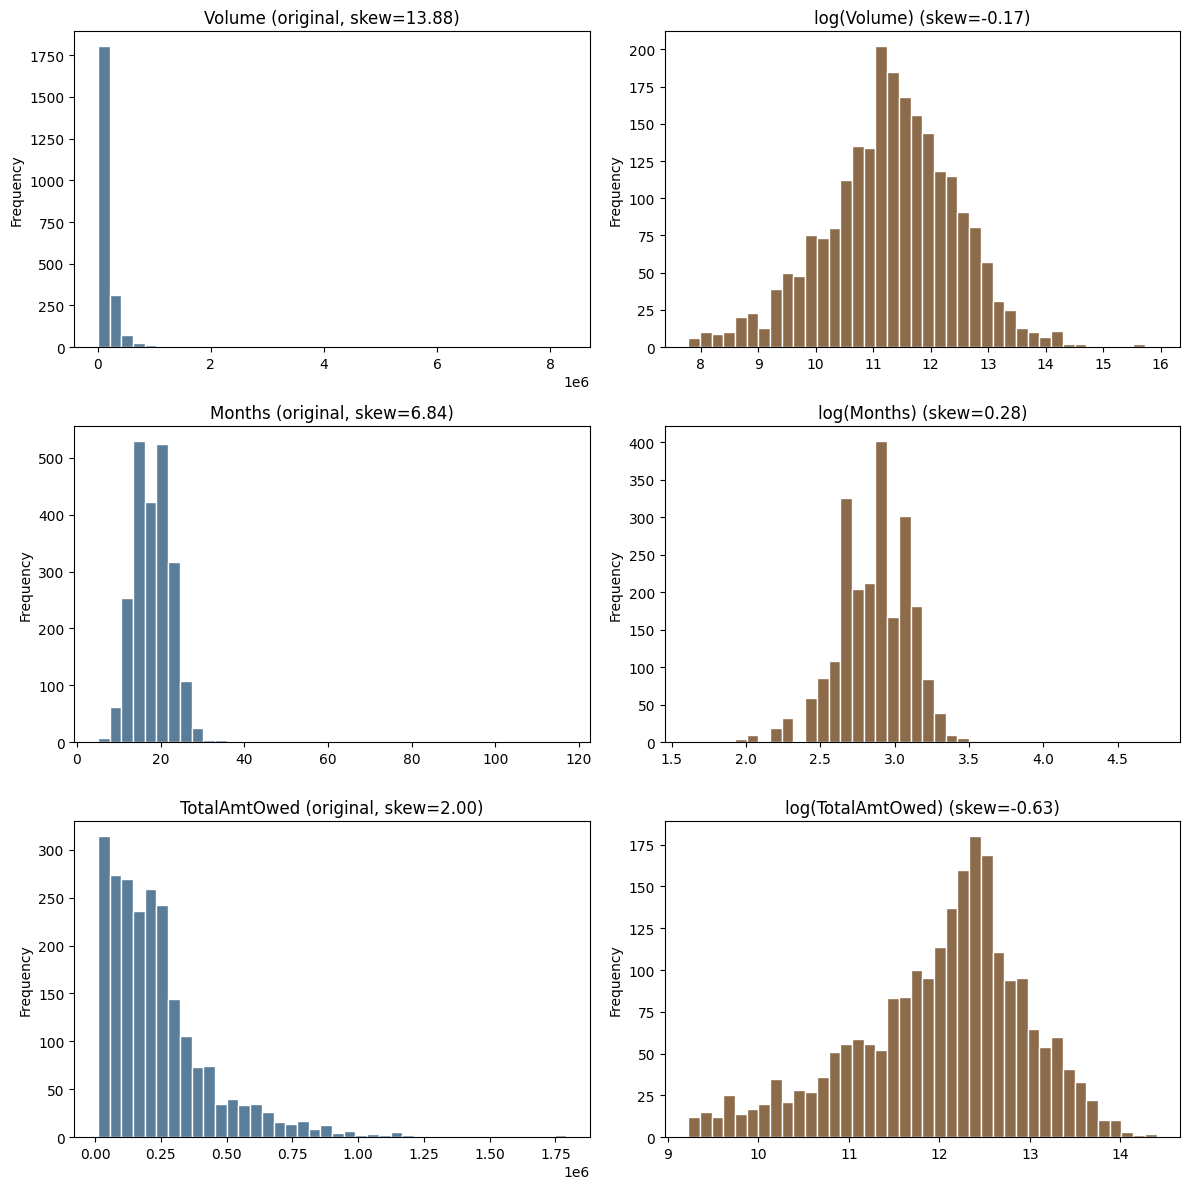

In [43]:
from scipy.stats import skew

vars_to_check = ['TotalAmtOwed', 'Volume', 'Stress',
                 'Num_CreditLines', 'Prop_Delinquent_Credit', 'Months']

# Compute skewness
skew_df = pd.DataFrame({
    'Variable': vars_to_check,
    'Skewness': [skew(data_df[v]) for v in vars_to_check],
    'Min': [data_df[v].min() for v in vars_to_check],
    'Max': [data_df[v].max() for v in vars_to_check],
    'Median': [data_df[v].median() for v in vars_to_check],
    'Mean': [data_df[v].mean() for v in vars_to_check],
})
display(skew_df)

# Plot original vs log-transformed distributions for candidate variables
candidates_for_log = ['Volume', 'Months', 'TotalAmtOwed']  # financial vars likely to be right-skewed

fig, axes = plt.subplots(len(candidates_for_log), 2, figsize=(12, 4 * len(candidates_for_log)))
for i, var in enumerate(candidates_for_log):
    vals = data_df[var]
    vals_pos = vals[vals > 0]

    axes[i, 0].hist(vals, bins=40, color='#5A7D9A', edgecolor='white')
    axes[i, 0].set_title(f'{var} (original, skew={skew(vals):.2f})')
    axes[i, 0].set_ylabel('Frequency')

    axes[i, 1].hist(np.log(vals_pos), bins=40, color='#8C6B4A', edgecolor='white')
    axes[i, 1].set_title(f'log({var}) (skew={skew(np.log(vals_pos)):.2f})')
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# solution: log-transform for 'Volume', 'Months', 'TotalAmtOwed'
for var in candidates_for_log:
    data_df[f'log_{var}'] = np.log(data_df[var].where(data_df[var] > 0))
    test_df[f'log_{var}'] = np.log(test_df[var].where(test_df[var] > 0))

## Data Split 
Split the data into `train` and `dev` sets for model building and validation.

In [44]:
from sklearn.model_selection import train_test_split

# Train/Dev split (80/20) with fixed random seed for reproducibility
train_df, dev_df = train_test_split(data_df, test_size=0.2, random_state=628)

print(f"Train set: {train_df.shape[0]} rows")
print(f"Dev set:   {dev_df.shape[0]} rows")
print(f"Test set (evaluation): {test_df.shape[0]} rows")

Train set: 1807 rows
Dev set:   452 rows
Test set (evaluation): 2500 rows


## PRSM Distribution
-  It's moderately skewed, so we keep it as-is for now. We will revisit after fitting the model (check residual diagnostics).

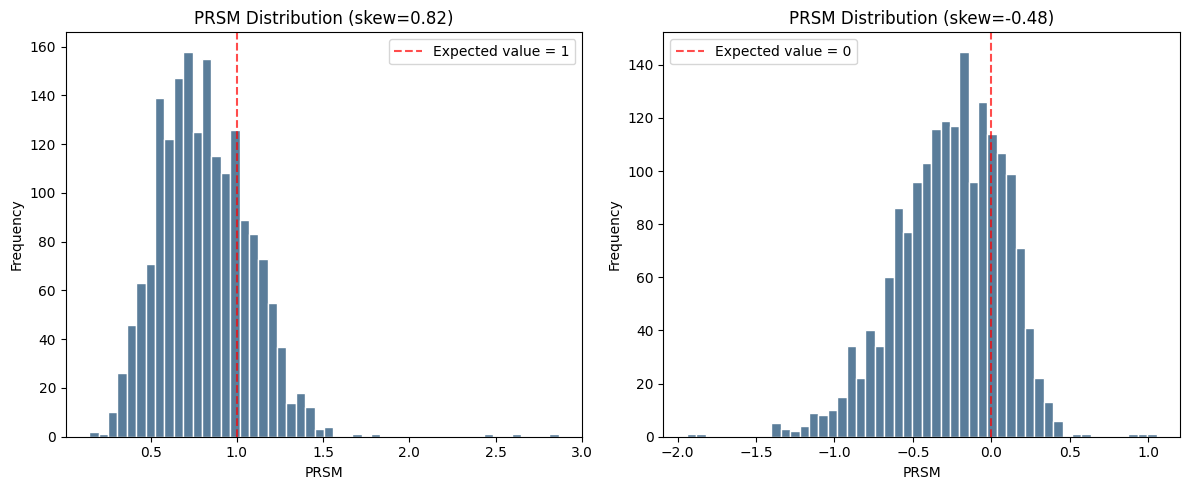

In [45]:
# Check PRSM (response) distribution — important for residual normality assumption
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(train_df['PRSM'], bins=50, color='#5A7D9A', edgecolor='white')
axes[0].set_title(f'PRSM Distribution (skew={skew(train_df["PRSM"]):.2f})')
axes[0].set_xlabel('PRSM')
axes[0].set_ylabel('Frequency')
axes[0].axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='Expected value = 1')
axes[0].legend()


axes[1].hist(np.log(train_df['PRSM']), bins=50, color='#5A7D9A', edgecolor='white')
axes[1].set_title(f'PRSM Distribution (skew={skew(np.log(train_df["PRSM"])):.2f})')
axes[1].set_xlabel('PRSM')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=0.0, color='red', linestyle='--', alpha=0.7, label='Expected value = 0')
axes[1].legend()


plt.tight_layout()
plt.show()

## Categorical Variables vs PRSM

We examine how `CorpStructure`, `WomanOwned`, and `NAICS_industry` relate to PRSM. For the regression model, categorical variables will be encoded as dummy/indicator variables. We need to check:
- Whether different categories have meaningfully different PRSM distributions.
- Whether any categories have too few observations to be reliable.

**Categorical variable observations:**

- **`CorpStructure`**: The median PRSM differs across Corp, LLC, Partner, Sole. 
- **`WomanOwned`**: Women-owned businesses show different PRSM patterns.
- **`NAICS_industry`**: Almost the same across different industry. But this variable could be related with other varisbles, we can't drop it.
- We'll apply dummy vars for all of them.

Industry sample sizes:
NAICS_industry
Retail Trade                       1407
Accommodation and Food Services     400
Name: count, dtype: int64


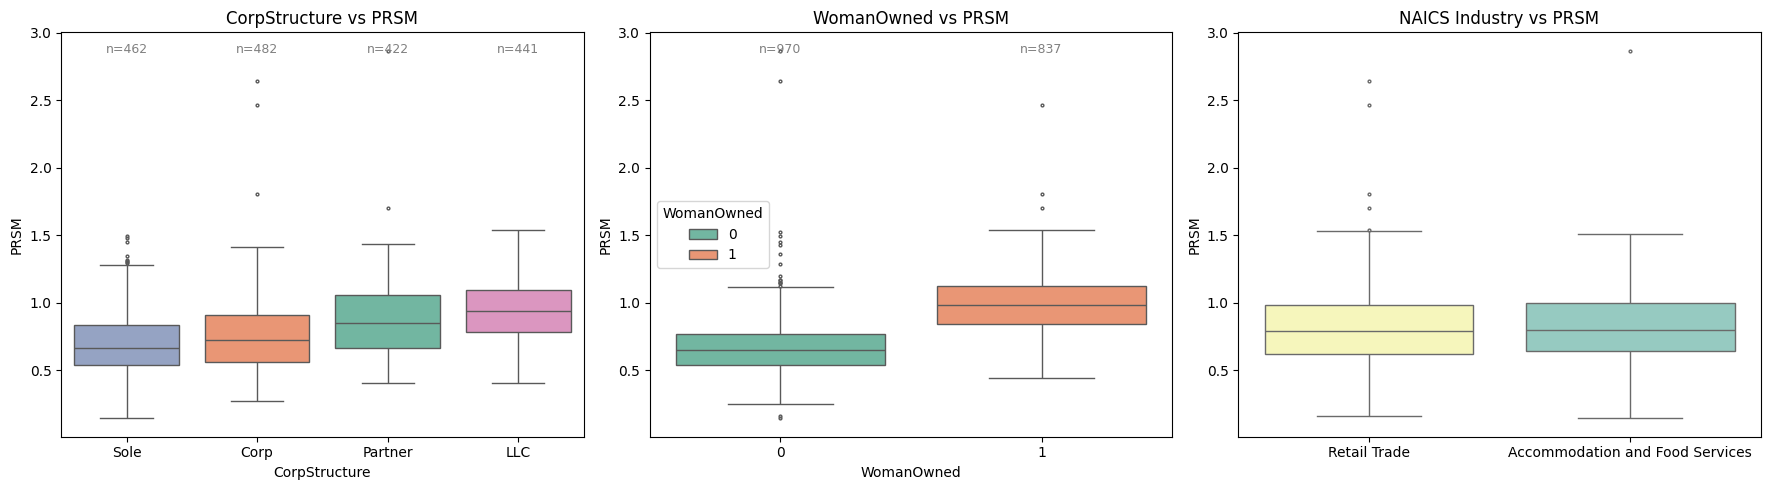

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. CorpStructure vs PRSM
order_corp = train_df.groupby('CorpStructure')['PRSM'].median().sort_values().index
sns.boxplot(data=train_df, x='CorpStructure', y='PRSM', order=order_corp, ax=axes[0],
            hue='CorpStructure', dodge=False, palette='Set2', fliersize=2)
axes[0].set_title('CorpStructure vs PRSM')
# annotate sample size
for i, cat in enumerate(order_corp):
    n = (train_df['CorpStructure'] == cat).sum()
    axes[0].text(i, axes[0].get_ylim()[1] * 0.95, f'n={n}', ha='center', fontsize=9, color='gray')

# 2. WomanOwned vs PRSM
sns.boxplot(data=train_df, x='WomanOwned', y='PRSM', ax=axes[1], hue='WomanOwned', dodge=False, palette='Set2', fliersize=2)
axes[1].set_title('WomanOwned vs PRSM')
for i, cat in enumerate([0, 1]):
    n = (train_df['WomanOwned'] == cat).sum()
    axes[1].text(i, axes[1].get_ylim()[1] * 0.95, f'n={n}', ha='center', fontsize=9, color='gray')

# 3. NAICS_industry vs PRSM (top industries by count)
top_industries = train_df['NAICS_industry'].value_counts()
print("Industry sample sizes:")
print(top_industries)
order_ind = train_df.groupby('NAICS_industry')['PRSM'].median().sort_values().index
sns.boxplot(data=train_df, x='NAICS_industry', y='PRSM', order=order_ind, ax=axes[2],
            hue='NAICS_industry', dodge=False, palette='Set3', fliersize=2)
axes[2].set_title('NAICS Industry vs PRSM')
axes[2].tick_params(axis='x', rotation=0)
axes[2].set_xlabel('')

plt.tight_layout()
plt.show()

# Solution: create dummy variables for CorpStructure and NAICS_industry and NAICS
train_df = pd.concat([train_df, pd.get_dummies(train_df['CorpStructure'], prefix='CorpStructure'), pd.get_dummies(train_df['NAICS_industry'], prefix='NAICS_ind'), pd.get_dummies(train_df['NAICS'], prefix='NAICS_code')], axis=1)
dev_df = pd.concat([dev_df, pd.get_dummies(dev_df['CorpStructure'], prefix='CorpStructure'), pd.get_dummies(dev_df['NAICS_industry'], prefix='NAICS_ind'), pd.get_dummies(dev_df['NAICS'], prefix='NAICS_code')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['CorpStructure'], prefix='CorpStructure'), pd.get_dummies(test_df['NAICS_industry'], prefix='NAICS_ind'), pd.get_dummies(test_df['NAICS'], prefix='NAICS_code')], axis=1)


## Discrete Variable vs PRSM

We examine how `FICO_Category` relate to PRSM.

**Categorical variable observations:**

- **`FICO_Category`**: PRSM differs across FICO categories. 

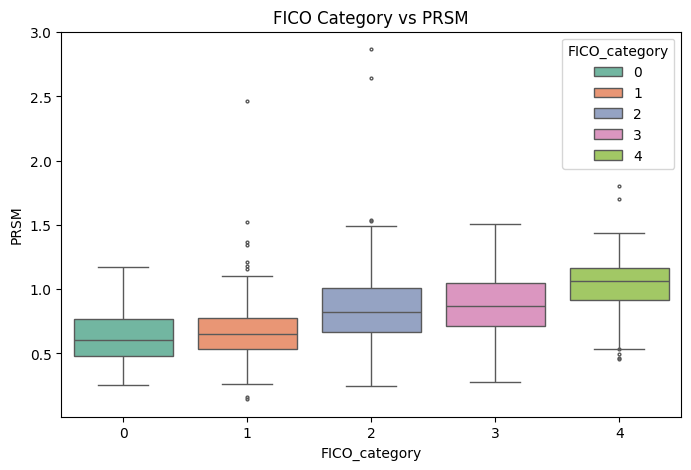

In [47]:
# FICO_category vs PRSM
fig, ax = plt.subplots(figsize=(8, 5))
order_fico = train_df.groupby('FICO_category')['PRSM'].median().sort_values().index
sns.boxplot(data=train_df, x='FICO_category', y='PRSM', order=order_fico, ax=ax,
            hue='FICO_category', dodge=False, palette='Set2', fliersize=2)
ax.set_title('FICO Category vs PRSM')
ax.tick_params(axis='x', rotation=0)


## Data Preparation for Modeling

### Variables entering the regression model

| Variable | Role | Transformation | Reason |
|---|---|---|---|
| `PRSM` | Response (y) | None | Revisit after residual check |
| `FICO_category` | Predictor | Discretization | Better explainability |
| `log(TotalAmtOwed)` | Predictor | log | Right-skewed financial variable; log reduces leverage of large values |
| `log(Volume)` | Predictor | log | Same reasoning as TotalAmtOwed |
| `Stress` | Predictor | None | Bounded ratio, moderate spread |
| `Num_CreditLines` | Predictor | None | Low skew, discrete |
| `Prop_Delinquent_Credit` | Predictor (new) | None | Ratio of delinquent / total credit lines — more informative than raw count |
| `log(Months)` | Predictor | log | Diminishing marginal effect of business age |
| `WomanOwned` | Predictor | Indicator (0/1) | Binary, no transform needed |
| `CorpStructure` | Predictor | Dummy encoding | Categorical with 4 levels |
| `NAICS_industry` | Predictor | Dummy encoding (grouped) | Binary |

### Dropped variables
- `Num_Delinquent`: Its information is captured by `Prop_Delinquent_Credit`.
- `NAICS` (raw 6-digit): Replaced by `NAICS_industry` (2-digit industry grouping).
- `FICO`: Replaced by `FICO_category`.

### Observations removed
- Records with negative PRSM (data error).


In [ ]:
# Save for downstream modeling
train_df.to_csv('./train_df.csv', index=False)
dev_df.to_csv('./dev_df.csv', index=False)
test_df.to_csv('./test_df.csv', index=False)
print("\nSaved train_df.csv, dev_df.csv, and test_df.csv")


Saved train_df.csv, dev_df.csv, and test_df.csv
